## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [23]:
! git clone https://github.com/JinMizar/PCA.git

fatal: destination path 'PCA' already exists and is not an empty directory.


### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [24]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()


,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [25]:
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


The tokens should be cleaned for better analysis and prediction. This includes: Converting all text to lowercase for uniformity. Removing punctuation, numbers, and special characters that may not add meaning. Removing stop words, such as "and", "the", "is", etc, that do not contribute to distinguishing phishing from safe emails. Then I would apply one-hot encoding, and we would deploy every token as a binary feature where that token has a column, and the 1 or 0 represents whether or not that token is present in the input email. These features would then be used as inputs to a predictive algorithm. To determine an email as phishing or not, I will perform PCA to reduce the dimensions of the token features and keep only the most significant components. Then, I would use a linear model to classify the emails based on these features. It keeps the pipeline efficient, easily interpretable, and aligned with the preferred methodologies discussed in class.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [26]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

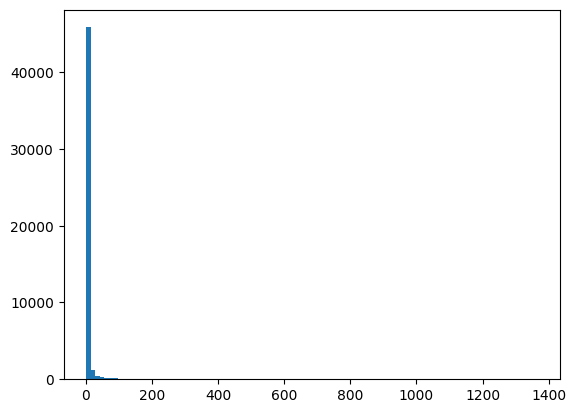

In [27]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

The histogram of token occurrences shows a highly skewed distribution, where a small number of tokens appear very frequently, represented by the tall bar at the lower end of the x-axis, while the majority of tokens occur infrequently, forming a long tail. This pattern suggests that a few words dominate the dataset in frequency while most are rare. This distribution indicates that very frequent tokens, such as generic words or phrases, may not add much value for distinguishing phishing emails from safe ones.


### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [29]:
df = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)
# Perform an 80/20 train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

#Run a regression of  y  on the one-hot-encoded emails
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [36]:
#What words have the largest coefficients in absolute value and most strongly influence predictions?
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The words with the largest coefficients in absolute value are "1999", "1995", "19", etc. and they have the most significant impact on the predictions

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

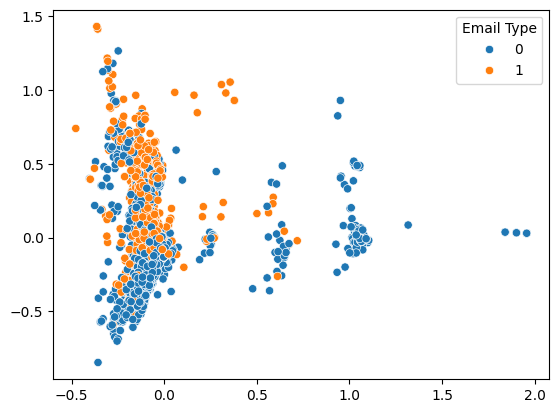

In [30]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The scatter plot of the first two principal components shows some separation between phishing and non-phishing emails, with phishing emails forming distinct clusters. However, there is overlap, indicating shared characteristics between the two types. This suggests that while PCA captures useful patterns, additional features or more advanced models may be needed for better classification.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [32]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


Using 2,610 principal components for linear regression resulted in a train R² of 0.6929 and a test R² of 0.5874. This approach outperformed the direct linear regression on one-hot-encoded features by improving generalization to the test set. The use of PCA reduced overfitting by focusing on the most important patterns in the data, while the original regression likely suffered from noise and redundancy in the full set of 2,711 features.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

It is a simplified summary of the data which keeps only the most significant composition of all variations and removes noise and redundancy. This makes the model more efficient, helps reduce overfitting, and improves generalization on new data. In contrast, directly using the original high-dimensional data often causes overfitting, because the model attempts to fit irrelevant or noisy features, leading to poor test performance. The principal components only capture the meaningful variance and as a result lead to a more robust model.